<a href="https://colab.research.google.com/github/Strata-Tech/MLresale/blob/main/Resale_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#!pip3 install pycaret[full]


!pip install --use-deprecated=legacy-resolver pycaret[full]

In [2]:
!pip3 install shap
!pip3 install pyarrow

# install lightgbm GPU
!pip3 install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)


In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# from pathlib import Path




from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [40]:
files=['/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-approval-date-1990-1999.csv','/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv','/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv','/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv','/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv','/content/drive/MyDrive/PCMLdata/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv']

In [41]:
for x in files:
    df=pd.read_csv(x)
    if x==files[0]:
        dataset=df
        
    else:
        dataset=pd.concat([dataset,df])

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exploring the data

In [8]:
dataset.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data cleaning

In [45]:
dataset.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'remaining_lease', 'new_remaining_lease'],
      dtype='object')

In [46]:
#number of null values
dataset.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709054
new_remaining_lease         0
dtype: int64

In [47]:
#creating new column to calculate remaining lease on our own to eradicate null values.
dataset['new_remaining_lease']=99-(2021-dataset['lease_commence_date'])
dataset.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,new_remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,55
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN,55
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN,55
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN,55
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN,54


In [48]:
dataset.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709054
new_remaining_lease         0
dtype: int64

In [49]:
dataset.drop(columns=(['remaining_lease']),inplace=True)

In [50]:
#cleaning flat_type field
dataset.loc[dataset['flat_type']=='MULTI GENERATION','flat_type']='MULTI-GENERATION'
print(dataset['flat_type'].unique())

['1 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE'
 'MULTI-GENERATION']


In [51]:
# Renaming of flat model duplicates
replace_values = {'NEW GENERATION':'New Generation', 'SIMPLIFIED':'Simplified', 'STANDARD':'Standard', 'MODEL A-MAISONETTE':'Maisonette', 'MULTI GENERATION':'Multi Generation', 'IMPROVED-MAISONETTE':'Executive Maisonette', 'Improved-Maisonette':'Executive Maisonette', 'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'MODEL A':'Model A', 'MAISONETTE':'Maisonette', 'Model A-Maisonette':'Maisonette', 'IMPROVED':'Improved', 'TERRACE':'Terrace', 'PREMIUM APARTMENT':'Premium Apartment', 'Premium Apartment Loft':'Premium Apartment', 'APARTMENT':'Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}

dataset = dataset.replace({'flat_model': replace_values})

dataset['flat_model'].value_counts()

Model A                 239532
Improved                226867
New Generation          183898
Simplified               55832
Standard                 41035
Premium Apartment        38597
Apartment                33426
Maisonette               29904
Model A2                  9685
DBSS                      1814
Adjoined flat             1135
Terrace                    666
Type S1S2                  593
Multi Generation           507
Executive Maisonette       202
2-room                      41
Name: flat_model, dtype: int64

In [52]:
#omitting 1 room flats as no longer relevant

dataset2=dataset[dataset['flat_type']!='1 ROOM']
dataset2[dataset2['flat_type']=='1 ROOM']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,new_remaining_lease


In [53]:
# Convert month(which actually refers to resale date) to a proper datetime format
dataset2['month'] = dataset2.month.apply(lambda x: pd.to_datetime(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
# Create a reference date, where the earliest date in the dataset is 0 and each 
# subsequent date increases by 1

# This will allow decision trees to group observations by dates in a very fine
# manner - Trend capturing.

# First get a de-duplicated list of sale date
# ## Then sort them
# ## Then create a incremental date using i += 1 for each consecutive date
dates = sorted(dataset2.month.drop_duplicates())

date_dict = {}
i = 0
for date in dates:
    date_dict[date] = i
    i += 1


print(date_dict)


{Timestamp('1990-01-01 00:00:00'): 0, Timestamp('1990-02-01 00:00:00'): 1, Timestamp('1990-03-01 00:00:00'): 2, Timestamp('1990-04-01 00:00:00'): 3, Timestamp('1990-05-01 00:00:00'): 4, Timestamp('1990-06-01 00:00:00'): 5, Timestamp('1990-07-01 00:00:00'): 6, Timestamp('1990-08-01 00:00:00'): 7, Timestamp('1990-09-01 00:00:00'): 8, Timestamp('1990-10-01 00:00:00'): 9, Timestamp('1990-11-01 00:00:00'): 10, Timestamp('1990-12-01 00:00:00'): 11, Timestamp('1991-01-01 00:00:00'): 12, Timestamp('1991-02-01 00:00:00'): 13, Timestamp('1991-03-01 00:00:00'): 14, Timestamp('1991-04-01 00:00:00'): 15, Timestamp('1991-05-01 00:00:00'): 16, Timestamp('1991-06-01 00:00:00'): 17, Timestamp('1991-07-01 00:00:00'): 18, Timestamp('1991-08-01 00:00:00'): 19, Timestamp('1991-09-01 00:00:00'): 20, Timestamp('1991-10-01 00:00:00'): 21, Timestamp('1991-11-01 00:00:00'): 22, Timestamp('1991-12-01 00:00:00'): 23, Timestamp('1992-01-01 00:00:00'): 24, Timestamp('1992-02-01 00:00:00'): 25, Timestamp('1992-03-01

In [55]:
# Apply the date dictionary to the dataframe and call this date feature date_id.
dataset2['date_id'] = dataset2.month.apply(lambda x: date_dict[x])

dataset2['date_id'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Location is important variable which affects resale prices. However from the dataset having it as street is not very useful. A more accurate measurement for location is lat lon which can direct us to the exact location and relativity to vincinity places. For this i have amended street to include block and using the OneMap API to derive the lat long of each unique location.


In [56]:

dataset2['street_name'].apply(lambda x: x).value_counts()

YISHUN RING RD        16830
BEDOK RESERVOIR RD    14241
ANG MO KIO AVE 10     13405
ANG MO KIO AVE 3      11826
HOUGANG AVE 8          8981
                      ...  
HOUGANG ST 32            10
OUTRAM HILL               9
TAMPINES ST 86            2
MARINE PARADE CTRL        2
SUMANG WALK               2
Name: street_name, Length: 568, dtype: int64

In [57]:
dataset2['address']=dataset2['block']+' '+dataset2['street_name']
dataset2['address'].apply(lambda x: x).value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


211 BOON LAY PL          807
208 BOON LAY PL          750
185 BOON LAY AVE         749
186 BOON LAY AVE         744
210 BOON LAY PL          739
                        ... 
96A HENDERSON RD           1
668B EDGEFIELD PLAINS      1
530B PASIR RIS DR 1        1
164A RIVERVALE CRES        1
256C SUMANG WALK           1
Name: address, Length: 9277, dtype: int64

In [58]:
locations=pd.DataFrame()

In [59]:
#generating a dataframe of unique addresses for resale flats
x=dataset2['address'].unique()
locations=pd.DataFrame(x)

In [60]:
locations.rename(columns={0:'address'},inplace=True)


In [25]:
locations

,address
0,216 ANG MO KIO AVE 1
1,211 ANG MO KIO AVE 3
2,202 ANG MO KIO AVE 3
3,235 ANG MO KIO AVE 3
4,232 ANG MO KIO AVE 3
...,...
9272,294A COMPASSVALE CRES
9273,468A FERNVALE LINK
9274,470C FERNVALE LINK
9275,164A RIVERVALE CRES


In [26]:
import requests

In [27]:
addresslist=list(locations['address'])

In [28]:
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

Defining a function as getcoordinates . Using the requests module, I will use it to search information on OneMap API. The address will have to be inserted as a string into the the given URL in order to retrieve information. Next, is to use the eval() function to evaluate it as a Python expression. As not all addresses will have coordinates, I use an if-else clause to only take those with results.

In [ ]:
coordinateslist= []
count = 0


failed_count = 0
for address in addresslist:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            print('Extracting',count,'out of',len(addresslist),'addresses')
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(addresslist),'addresses')
        coordinateslist.append(None)
print('Total Number of Addresses With No Coordinates',failed_count)

Extracting 1 out of 9277 addresses
Extracting 2 out of 9277 addresses
Extracting 3 out of 9277 addresses
Extracting 4 out of 9277 addresses
Extracting 5 out of 9277 addresses
Extracting 6 out of 9277 addresses
Extracting 7 out of 9277 addresses
Extracting 8 out of 9277 addresses
Failed to extract 9 out of 9277 addresses
Extracting 10 out of 9277 addresses
Failed to extract 11 out of 9277 addresses
Extracting 12 out of 9277 addresses
Extracting 13 out of 9277 addresses
Extracting 14 out of 9277 addresses
Extracting 15 out of 9277 addresses
Extracting 16 out of 9277 addresses
Extracting 17 out of 9277 addresses
Extracting 18 out of 9277 addresses
Extracting 19 out of 9277 addresses
Extracting 20 out of 9277 addresses
Extracting 21 out of 9277 addresses
Extracting 22 out of 9277 addresses
Extracting 23 out of 9277 addresses
Extracting 24 out of 9277 addresses
Extracting 25 out of 9277 addresses
Extracting 26 out of 9277 addresses
Extracting 27 out of 9277 addresses
Extracting 28 out of 92

In [ ]:
df_coordinates = pd.DataFrame(coordinateslist)
df_coordinates

,0,1
0,1.36619678831054,103.841505011903
1,1.369196965617,103.841666636086
2,1.36844644010937,103.844516260527
3,1.36682360872342,103.83649123351
4,1.36834606813391,103.837196046409
...,...,...
9272,1.39606977416428,103.895933432889
9273,1.39747908543717,103.878500081571
9274,1.39619403936395,103.879992372196
9275,1.39007029696728,103.907273221559


In [ ]:
df_coordinates.rename(columns={0:'lat',1:'long'},inplace=True)
df_coordinates

,lat,long
0,1.36619678831054,103.841505011903
1,1.369196965617,103.841666636086
2,1.36844644010937,103.844516260527
3,1.36682360872342,103.83649123351
4,1.36834606813391,103.837196046409
...,...,...
9272,1.39606977416428,103.895933432889
9273,1.39747908543717,103.878500081571
9274,1.39619403936395,103.879992372196
9275,1.39007029696728,103.907273221559


In [2]:
new2=pd.concat([locations,df_coordinates],axis=1)
new2.head()



NameError: ignored

In [1]:
new2.to_csv('latlong.csv')

NameError: ignored

In [ ]:
new=pd.merge(dataset2,new2,how='outer',on='address')

In [ ]:
#dataset with lat lon in place!
new.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,new_remaining_lease,date_id,address,lat,long
0,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,47200.0,54,0,216 ANG MO KIO AVE 1,1.36619678831054,103.841505011903
1,1990-03-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,47000.0,54,2,216 ANG MO KIO AVE 1,1.36619678831054,103.841505011903
2,1990-05-01,ANG MO KIO,4 ROOM,216,ANG MO KIO AVE 1,10 TO 12,88.0,New Generation,1976,55000.0,54,4,216 ANG MO KIO AVE 1,1.36619678831054,103.841505011903
3,1990-08-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,10 TO 12,73.0,New Generation,1976,47200.0,54,7,216 ANG MO KIO AVE 1,1.36619678831054,103.841505011903
4,1990-08-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,01 TO 03,73.0,New Generation,1976,34000.0,54,7,216 ANG MO KIO AVE 1,1.36619678831054,103.841505011903


In [ ]:
new['lease_commence_date']=pd.to_datetime(new['lease_commence_date'])

In [4]:
new.to_csv('collate.csv')

NameError: ignored

In [61]:
new=pd.read_csv('/content/drive/MyDrive/PCMLdata/collate.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  return eval(expr, self.user_global_ns, self.user_ns)


In [10]:
# Do a final check on the summary statistics
new.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the features i will ignore:
1.Month, i have represented this as date_id in the model which is a better measurement
2.Block,Street name, address will also be ignored as i will be representing this with lat long

In [63]:
!pip install pyyaml==5.4.1

In [64]:
from pycaret.regression import *

TypeError: ignored

In [13]:
resale_model = setup(
    data=new,
    target='resale_price',
   
    categorical_features=['storey_range', 'flat_type', 'flat_model'],
    ignore_features=['Unnamed: 0','month','block', 'address', 'street_name'],
    numeric_features=['new_remaining_lease','date_id']
   
   
    )

NameError: ignored

In [ ]:
# compare_models(include=['rf', 'xgboost', 'lightgbm', 'dt', 'lasso', 'catboost', 'knn', 'lr'])

compare_models(include=['rf', 'xgboost', 'lightgbm', 'dt',  'catboost', 'lr'])

IntProgress(value=0, description='Processing: ', max=34)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:31:00
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)


 Next I create a few models with the good results to compare

In [ ]:
# Create a model object with the best mape
best_model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,12928.5575,3.559818e+08,18867.4802,0.9844,0.0764,0.0511
1,12953.8242,3.592047e+08,18952.6965,0.9844,0.0753,0.0507
2,12919.7351,3.495219e+08,18695.5038,0.9846,0.0763,0.0513
3,12885.7703,3.502600e+08,18715.2344,0.9845,0.0761,0.0511
4,12942.9340,3.583868e+08,18931.1069,0.9844,0.0754,0.0507
5,12805.8049,3.497945e+08,18702.7942,0.9845,0.0755,0.0506
6,12763.1683,3.523416e+08,18770.7654,0.9844,0.0752,0.0504
7,12935.1939,3.600376e+08,18974.6575,0.9841,0.0753,0.0509
8,12860.0715,3.546521e+08,18832.2092,0.9844,0.0753,0.0509
9,12840.2598,3.523001e+08,18769.6598,0.9846,0.0756,0.0507


From the above we can see that the mean error rate of our best model random forest is 5%. Also the model is very stable as the standard deviation is very small in this instance.

In [ ]:
# We will also choose a few more models that perform well but not of the same class if possible.
xgb = create_model('xgboost')
ctb = create_model('catboost')
br = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,49304.6425,4.172344e+09,64593.6830,0.8177,0.2933,0.2070
1,49332.2822,4.159134e+09,64491.3484,0.8191,0.2935,0.2078
2,49471.8542,4.187540e+09,64711.2067,0.8160,0.2870,0.2084
3,48944.0360,4.090655e+09,63958.2321,0.8192,0.2952,0.2071
4,49429.0214,4.170601e+09,64580.1877,0.8187,0.2912,0.2093
5,49043.9902,4.101241e+09,64040.9354,0.8187,0.2934,0.2078
6,49192.2968,4.145600e+09,64386.3312,0.8167,0.2950,0.2065
7,49273.8994,4.158057e+09,64482.9989,0.8167,0.2962,0.2085
8,49197.1905,4.142313e+09,64360.8009,0.8177,0.2915,0.2088
9,49279.4421,4.152341e+09,64438.6570,0.8181,0.2931,0.2074


In [ ]:
# Compute the MAPD for xgb model

test_results_xgb = predict_model(xgb)
mapd = np.median(abs(test_results_xgb.resale_price - test_results_xgb.Label)/test_results_xgb.resale_price)
print(f'The Median Absolute % Deviation is {mapd * 100:.2f}%')

In [ ]:
# This is the accuracy of rf on the test data. This is more in line with its
# training performance.
test_results_rf = predict_model(rf)

# Compute the MAPD for the selected model
mapd = np.median(abs(test_results_rf.resale_price - test_results_rf.Label)/test_results_rf.resale_price)
print(f'The Median Absolute % Deviation is {mapd * 100:.2f}%')

In [ ]:
plot_model(xgb, plot='residuals_interactive')

In [ ]:
plot_model(xgb, plot='learning')

### Explaining the model

In [ ]:
# Compare this plot with the next plot (which features catboost)
plot_model(rf, plot='feature')

In [ ]:
# Catboost seems to provide better explainability, but its test accuracy is not as stable.
# We should increase the sample size and see if its a sampling issue.

plot_model(ctb, plot='feature')

In [ ]:
# Compare to a linear regression. This is definitely weaker from an explainability perspective.
lr_model = create_model('lr')

# Plot feature importance
plot_model(lr_model, plot='feature')

In [ ]:
# Plot a SHAP interpretation of the model
interpret_model(ctb)

In [ ]:
interpret_model(ctb, plot='reason', observation=100)

### Finalize the Model

In [ ]:
# Once we are happy with the results, we can train the model using 100% of the data
final_model = finalize_model(best_model)

We can save the trained model into a file, pass it to the software engineer to integrate into the solution

In [ ]:
from datetime import datetime
current_date = datetime.now().date()

In [76]:
# Load data
data_path = Path('/content/drive/My Drive/pcml_data/5SML')
filename = 'collated.csv'

df = pd.read_csv(data_path / filename)

NameError: ignored

In [ ]:
# Save the model
model_filepath = data_path / f'autovaluation_{current_date}'
save_model(final_model, model_name=model_filepath)

In [6]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862447 entries, 0 to 862446
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           862447 non-null  int64  
 1   month                862447 non-null  object 
 2   town                 862447 non-null  object 
 3   flat_type            862447 non-null  object 
 4   block                862447 non-null  object 
 5   street_name          862447 non-null  object 
 6   storey_range         862447 non-null  object 
 7   floor_area_sqm       862447 non-null  float64
 8   flat_model           862447 non-null  object 
 9   lease_commence_date  862447 non-null  int64  
 10  resale_price         862447 non-null  float64
 11  new_remaining_lease  862447 non-null  int64  
 12  date_id              862447 non-null  int64  
 13  address              862447 non-null  object 
 14  lat                  850884 non-null  float64
 15  long             

In [65]:
new.dropna(inplace=True)

In [66]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850884 entries, 0 to 862446
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           850884 non-null  int64  
 1   month                850884 non-null  object 
 2   town                 850884 non-null  object 
 3   flat_type            850884 non-null  object 
 4   block                850884 non-null  object 
 5   street_name          850884 non-null  object 
 6   storey_range         850884 non-null  object 
 7   floor_area_sqm       850884 non-null  float64
 8   flat_model           850884 non-null  object 
 9   lease_commence_date  850884 non-null  int64  
 10  resale_price         850884 non-null  float64
 11  new_remaining_lease  850884 non-null  int64  
 12  date_id              850884 non-null  int64  
 13  address              850884 non-null  object 
 14  lat                  850884 non-null  float64
 15  long             

In [67]:
def convert(x):
  if x=='EXECUTIVE':
    x='6'
  elif x=='MULTI-GENERATION':
    x='7'
  return x

In [68]:
new['flat_type']=new['flat_type'].apply(convert)

In [69]:
new['flat_type'].unique()

array(['3 ROOM', '4 ROOM', '6', '5 ROOM', '2 ROOM', '7'], dtype=object)

In [72]:
new['room']=new['flat_type'].str.split(' ', 1,expand=True)
new['room']

0         3
1         3
2         4
3         3
4         3
         ..
862442    5
862443    4
862444    4
862445    5
862446    3
Name: room, Length: 850884, dtype: object

In [73]:
new['room']=new['room'].astype(int)

In [74]:
new['room'].unique()

array([3, 4, 6, 5, 2, 7])

In [76]:
X=new[['floor_area_sqm','lease_commence_date','new_remaining_lease','date_id','lat','long','room']].astype(float)
y=new['resale_price']

In [77]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850884 entries, 0 to 862446
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       850884 non-null  float64
 1   lease_commence_date  850884 non-null  float64
 2   new_remaining_lease  850884 non-null  float64
 3   date_id              850884 non-null  float64
 4   lat                  850884 non-null  float64
 5   long                 850884 non-null  float64
 6   room                 850884 non-null  float64
dtypes: float64(7)
memory usage: 51.9 MB


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [79]:
X_train, X_test, y_train, y_test 

(        floor_area_sqm  lease_commence_date  new_remaining_lease  date_id  \
 332912           118.0               1980.0                 58.0     43.0   
 196315            92.0               1978.0                 56.0    141.0   
 507659           103.0               1989.0                 67.0    246.0   
 857391            46.0               2015.0                 93.0    358.0   
 632036           123.0               1993.0                 71.0    281.0   
 ...                ...                  ...                  ...      ...   
 714420           100.0               1998.0                 76.0    359.0   
 567690            73.0               1989.0                 67.0    334.0   
 755911           116.0               1999.0                 77.0    190.0   
 294810           113.0               1984.0                 62.0    123.0   
 37429             68.0               1982.0                 60.0    323.0   
 
              lat        long  room  
 332912  1.328713  103.9

In [80]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [81]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
y_train

332912    250000.0
196315    212000.0
507659    377000.0
857391    224000.0
632036    537000.0
            ...   
714420    352000.0
567690    265000.0
755911    264000.0
294810    250000.0
37429     305000.0
Name: resale_price, Length: 680707, dtype: float64

In [83]:
# define the model
#Experiment with deeper and wider networks
model = Sequential()
model.add(Dense(128, input_dim=7, activation='relu'))
model.add(Dense(64, activation='relu'))
#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs =10)



Epoch 1/10
17018/17018 [==============================] - 32s 2ms/step - loss: 13726195712.0000 - mae: 78655.4688 - val_loss: 4898450944.0000 - val_mae: 52682.6758
Epoch 2/10
17018/17018 [==============================] - 33s 2ms/step - loss: 4747895808.0000 - mae: 51727.4648 - val_loss: 4649737216.0000 - val_mae: 51072.9648
Epoch 3/10
17018/17018 [==============================] - 33s 2ms/step - loss: 4561372672.0000 - mae: 50523.2148 - val_loss: 4498097664.0000 - val_mae: 49944.0547
Epoch 4/10
17018/17018 [==============================] - 31s 2ms/step - loss: 4442155008.0000 - mae: 49685.3945 - val_loss: 4411228160.0000 - val_mae: 49416.8945
Epoch 5/10
17018/17018 [==============================] - 33s 2ms/step - loss: 4379908608.0000 - mae: 49252.7148 - val_loss: 4363780608.0000 - val_mae: 49166.6523
Epoch 6/10
17018/17018 [==============================] - 32s 2ms/step - loss: 4337707008.0000 - mae: 48977.6328 - val_loss: 4330524160.0000 - val_mae: 49023.4336
Epoch 7/10
17018/1701

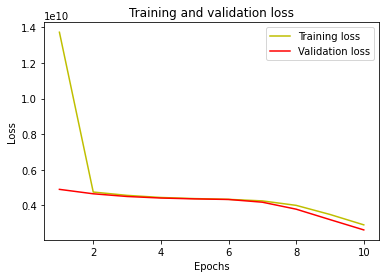

In [85]:




#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

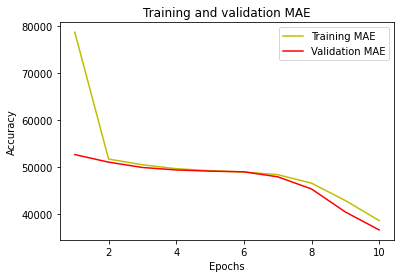

In [86]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [87]:
#Predict on test data
predictions = model.predict(X_test_scaled[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

Predicted values are:  [[140067.81]
 [325450.97]
 [255665.64]
 [231771.55]
 [144937.4 ]]
Real values are:  442893    160000.0
628700    285000.0
683016    220000.0
329511    207000.0
189324    156500.0
Name: resale_price, dtype: float64


In [88]:
#Comparison with other models..
#Neural network - from the current code
mse_neural, mae_neural = model.evaluate(X_test_scaled, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

5319/5319 [==============================] - 6s 1ms/step - loss: 2608314624.0000 - mae: 36600.5078
Mean squared error from neural net:  2608314624.0
Mean absolute error from neural net:  36600.5078125


In [89]:
#Linear regression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Linear regression
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)

Mean squared error from linear regression:  5368693144.270787
Mean absolute error from linear regression:  54694.79819724088


In [90]:
#Random forest.
#Increase number of tress and see the effect
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 30, random_state=30)
model.fit(X_train_scaled, y_train)

y_pred_RF = model.predict(X_test_scaled)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error Using Random Forest: ', mae_RF)

Mean squared error using Random Forest:  444673561.751386
Mean absolute error Using Random Forest:  14543.117874130878


In [91]:
#Feature ranking...
import pandas as pd
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)

date_id                0.476035
floor_area_sqm         0.323114
lat                    0.071021
room                   0.056945
long                   0.045659
lease_commence_date    0.013920
new_remaining_lease    0.013305
dtype: float64
